In [1]:
from collections import namedtuple

import numpy as np
import pandas as pd

import scikit_posthocs as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols

import statsmodels.api as sm
import pylab as py
from skimage import io

In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [10]:
data = pd.read_csv('data_personalitytransfer_2020-12-21_19-44.csv', sep=';')
data.head()

,CASE,SERIAL,REF,QUESTNNR,MODE,STARTED,WC02,WC03,AN01_01,AN01_02,...,MAILSENT,LASTDATA,FINISHED,Q_VIEWER,LASTPAGE,MAXPAGE,MISSING,MISSREL,TIME_RSI,DEG_TIME
0,25,NaN,NaN,base,interview,2020-12-16 11:00:42,1,5,3.0,3.0,...,NaN,2020-12-16 12:15:04,1,0,3,3,0,0,1.43,52
1,30,NaN,NaN,base,interview,2020-12-16 11:09:30,1,3,4.0,1.0,...,NaN,2020-12-16 11:53:16,1,0,3,3,0,0,1.42,50
2,31,NaN,NaN,base,interview,2020-12-16 11:11:05,1,5,3.0,3.0,...,NaN,2020-12-16 11:36:23,1,0,3,3,0,0,0.65,0
3,33,NaN,NaN,base,interview,2020-12-16 11:18:52,2,2,4.0,2.0,...,NaN,2020-12-16 11:43:59,1,0,3,3,0,0,0.57,0
4,36,NaN,NaN,base,interview,2020-12-16 11:26:43,1,3,5.0,1.0,...,NaN,2020-12-16 11:40:30,1,0,3,3,0,0,1.20,17


In [11]:
data.rename(str.lower, axis='columns', inplace=True)

In [12]:
data = data[data['finished'] == 1]

In [13]:
data.drop(columns = ['case', 'serial', 'ref', 'questnnr', 'mode', 'started', 'mailsent', \
                     'lastdata', 'finished', 'q_viewer', 'lastpage', 'maxpage', 'missing', \
                     'missrel', 'time_rsi', 'deg_time', 'time001', 'time002', 'time003'], inplace=True)

In [14]:
data.rename(columns={'wc02' : 'gender', 'wc03' : 'age'}, inplace=True)

In [15]:
data.reset_index(drop=True, inplace=True)

In [16]:
data = data.replace(-9.0, np.nan)
print(data.T.isnull().sum())

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11    10
12     1
13     1
14     1
15     5
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     5
26     0
27     0
28     0
29     5
30    10
31     5
32     0
33     0
34     1
dtype: int64


In [17]:
# reverse values of the 4th question (emotionally stable --> neurotic)
cols = [col for col in data.columns if '_04' in col]
for col in cols:
    for i in range(len(data)):
        data.loc[i, col] = abs(data.loc[i, col] - 6)

In [18]:
data.head()

,gender,age,an01_01,an01_02,an01_03,an01_04,an01_05,an02_01,an02_02,an02_03,...,sc09_02,sc09_03,sc09_04,sc09_05,sc10_01,sc10_02,sc10_03,sc10_04,sc10_05,time_sum
0,1,5,3.0,3.0,3.0,3.0,3.0,4.0,2.0,4.0,...,2.0,2.0,4.0,3.0,2.0,3.0,2.0,4.0,3.0,714
1,1,3,4.0,1.0,3.0,2.0,4.0,2.0,1.0,3.0,...,2.0,2.0,1.0,3.0,4.0,2.0,3.0,2.0,4.0,715
2,1,5,3.0,3.0,4.0,2.0,4.0,4.0,1.0,4.0,...,4.0,5.0,1.0,5.0,3.0,3.0,3.0,3.0,3.0,1517
3,2,2,4.0,2.0,2.0,3.0,4.0,4.0,2.0,1.0,...,2.0,3.0,4.0,1.0,4.0,2.0,2.0,2.0,1.0,1130
4,1,3,5.0,1.0,1.0,5.0,5.0,2.0,2.0,5.0,...,2.0,2.0,3.0,2.0,4.0,4.0,2.0,4.0,2.0,827


### Demographics

In [19]:
data['age'] = data['age'] - 1

In [20]:
mean_age = 18 + data['age'].mean()
mean_age

21.6

In [21]:
count_males = len(data[data['gender'] == 1])
count_males

25

In [22]:
count_females = len(data[data['gender'] == 2])
count_females

10

### User Evaluation

In [23]:
evals = data.iloc[:, 2:-1]
evals.head()

,an01_01,an01_02,an01_03,an01_04,an01_05,an02_01,an02_02,an02_03,an02_04,an02_05,...,sc09_01,sc09_02,sc09_03,sc09_04,sc09_05,sc10_01,sc10_02,sc10_03,sc10_04,sc10_05
0,3.0,3.0,3.0,3.0,3.0,4.0,2.0,4.0,2.0,3.0,...,3.0,2.0,2.0,4.0,3.0,2.0,3.0,2.0,4.0,3.0
1,4.0,1.0,3.0,2.0,4.0,2.0,1.0,3.0,2.0,3.0,...,4.0,2.0,2.0,1.0,3.0,4.0,2.0,3.0,2.0,4.0
2,3.0,3.0,4.0,2.0,4.0,4.0,1.0,4.0,3.0,4.0,...,4.0,4.0,5.0,1.0,5.0,3.0,3.0,3.0,3.0,3.0
3,4.0,2.0,2.0,3.0,4.0,4.0,2.0,1.0,4.0,4.0,...,4.0,2.0,3.0,4.0,1.0,4.0,2.0,2.0,2.0,1.0
4,5.0,1.0,1.0,5.0,5.0,2.0,2.0,5.0,3.0,2.0,...,4.0,2.0,2.0,3.0,2.0,4.0,4.0,2.0,4.0,2.0


In [24]:
distr = evals.apply(lambda x: x.value_counts()).T
# print(distr.head())
# distr.drop(distr.columns[0], axis=1, inplace=True)
distr.rename(columns={1.0:'SD', 2.0:'D', 3.0:'N', 4.0:'A', 5.0:'SA'}, inplace=True)
distr.fillna(0, inplace=True)
distr

,SD,D,N,A,SA
an01_01,2.0,2.0,3.0,13.0,15.0
an01_02,5.0,4.0,14.0,7.0,5.0
an01_03,3.0,9.0,15.0,6.0,2.0
an01_04,6.0,11.0,9.0,5.0,4.0
an01_05,1.0,0.0,11.0,10.0,13.0
...,...,...,...,...,...
sc10_01,13.0,4.0,6.0,9.0,3.0
sc10_02,5.0,12.0,14.0,3.0,1.0
sc10_03,5.0,8.0,14.0,5.0,3.0
sc10_04,0.0,6.0,12.0,7.0,10.0


In [25]:
mean_evals = evals.mean()
mean_per_img = [mean_evals[i*5:(i+1)*5] for i in range(0,len(mean_evals)//5)]

In [26]:
rows = []

for i in range(len(mean_per_img)):
    row = []
    img = mean_per_img[i]
    row.append(img.index[0][0:4])
    for i in range(5):
        row.append(img[i])
    rows.append(row)

In [27]:
per_img_mean_df = pd.DataFrame(rows, columns = ['img', 'extraversion', 'agreeableness', 'conscientiousness', 'neuroticism', 'openness'])
per_img_mean_df.head()

,img,extraversion,agreeableness,conscientiousness,neuroticism,openness
0,an01,4.057143,3.085714,2.857143,2.714286,3.971429
1,an02,3.235294,2.000000,3.294118,3.088235,2.970588
2,an03,2.685714,3.142857,3.485714,2.828571,3.171429
3,an04,4.057143,3.200000,3.142857,2.542857,4.028571
4,an05,3.085714,2.457143,2.942857,3.400000,2.971429


In [28]:
per_img_mean_df['emotion'] = 0
per_img_mean_df.iloc[:10, 6] = 'angry'
per_img_mean_df.iloc[10:20, 6] = 'happy'
per_img_mean_df.iloc[20:30, 6] = 'sad'
per_img_mean_df.iloc[30:40, 6] = 'scared'
per_img_mean_df.head()

,img,extraversion,agreeableness,conscientiousness,neuroticism,openness,emotion
0,an01,4.057143,3.085714,2.857143,2.714286,3.971429,angry
1,an02,3.235294,2.000000,3.294118,3.088235,2.970588,angry
2,an03,2.685714,3.142857,3.485714,2.828571,3.171429,angry
3,an04,4.057143,3.200000,3.142857,2.542857,4.028571,angry
4,an05,3.085714,2.457143,2.942857,3.400000,2.971429,angry


In [29]:
# normalize to satisfy the assumption that the data for each
# factor level is normally distributed

"""
normed = per_img_mean_df.copy(deep=True)
normed.head()

for emotion in ['angry', 'happy', 'sad', 'scared']:
    for factor in ['extraversion', 'agreeableness', 'conscientiousness',
                   'neuroticism', 'openness']:
        normed[factor][normed['emotion'] == emotion] = stats.boxcox(normed[factor][normed['emotion'] == emotion])[0]
        
normed
"""

"\nnormed = per_img_mean_df.copy(deep=True)\nnormed.head()\n\nfor emotion in ['angry', 'happy', 'sad', 'scared']:\n    for factor in ['extraversion', 'agreeableness', 'conscientiousness',\n                   'neuroticism', 'openness']:\n        normed[factor][normed['emotion'] == emotion] = stats.boxcox(normed[factor][normed['emotion'] == emotion])[0]\n        \nnormed\n"

In [30]:
per_img_mean_df_T = per_img_mean_df.T
per_img_mean_df_T.columns = per_img_mean_df_T.iloc[0, :]
per_img_mean_df_T.drop(['img'], inplace=True)
per_img_mean_df_T.columns.name = ''
per_img_mean_df_T.head()

,an01,an02,an03,an04,an05,an06,an07,an08,an09,an10,...,sc01,sc02,sc03,sc04,sc05,sc06,sc07,sc08,sc09,sc10
extraversion,4.05714,3.23529,2.68571,4.05714,3.08571,3.17647,3.68571,2.6,2.71429,3.62857,...,3.51429,3.88571,3.42857,3.51429,1.71429,2.14286,3.34286,3.97143,3.61765,2.57143
agreeableness,3.08571,2,3.14286,3.2,2.45714,2.58824,3.05714,2.62857,2.8,3.4,...,2.88571,2.45714,2.77143,2.42857,2.8,2.74286,2.97143,3.37143,2.88235,2.51429
conscientiousness,2.85714,3.29412,3.48571,3.14286,2.94286,3.05882,2.82857,2.74286,3.37143,3.4,...,2.61765,2.45714,2.54286,3.2,2.85714,2.42857,3.25714,3.02857,2.79412,2.8
neuroticism,2.71429,3.08824,2.82857,2.54286,3.4,3.26471,2.91429,3.47059,3.22857,2.94286,...,3.28571,3.22857,3.22857,2.77143,3.77143,3.88571,2.8,3.28571,2.58824,3.6
openness,3.97143,2.97059,3.17143,4.02857,2.97143,2.88235,3.34286,2.6,2.8,3.6,...,3.42857,3.45714,3.17143,3,2.45714,2.22857,3.31429,3.85714,3.38235,2.57143


In [31]:
angry = per_img_mean_df_T.iloc[:, :10]
happy = per_img_mean_df_T.iloc[:, 10:20]
sad = per_img_mean_df_T.iloc[:, 20:30]
scared = per_img_mean_df_T.iloc[:, 30:]

In [32]:
E = pd.DataFrame({'angry' : list(angry.iloc[0, :]),
                 'happy' : list(happy.iloc[0, :]),
                 'sad' : list(sad.iloc[0, :]),
                 'scared' : list(scared.iloc[0, :])})

A = pd.DataFrame({'angry' : list(angry.iloc[1, :]),
                 'happy' : list(happy.iloc[1, :]),
                 'sad' : list(sad.iloc[1, :]),
                 'scared' : list(scared.iloc[1, :])})

C = pd.DataFrame({'angry' : list(angry.iloc[2, :]),
                 'happy' : list(happy.iloc[2, :]),
                 'sad' : list(sad.iloc[2, :]),
                 'scared' : list(scared.iloc[2, :])})

N = pd.DataFrame({'angry' : list(angry.iloc[3, :]),
                 'happy' : list(happy.iloc[3, :]),
                 'sad' : list(sad.iloc[3, :]),
                 'scared' : list(scared.iloc[3, :])})

O = pd.DataFrame({'angry' : list(angry.iloc[4, :]),
                 'happy' : list(happy.iloc[4, :]),
                 'sad' : list(sad.iloc[4, :]),
                 'scared' : list(scared.iloc[4, :])})

In [33]:
E.mean()

angry     3.292605
happy     3.839664
sad       2.094370
scared    3.170336
dtype: float64

In [34]:
N.mean()

angry     3.039496
happy     2.945210
sad       3.665042
scared    3.244538
dtype: float64

In [35]:
O.mean()

angry     3.233866
happy     3.534874
sad       2.406303
scared    3.086807
dtype: float64

In [36]:
A.mean()

angry     2.835966
happy     3.158319
sad       2.673529
scared    2.782521
dtype: float64

In [37]:
C.mean()

angry     3.112437
happy     3.041597
sad       2.820420
scared    2.798319
dtype: float64

In [38]:
per_img_mean_df.head()

,img,extraversion,agreeableness,conscientiousness,neuroticism,openness,emotion
0,an01,4.057143,3.085714,2.857143,2.714286,3.971429,angry
1,an02,3.235294,2.000000,3.294118,3.088235,2.970588,angry
2,an03,2.685714,3.142857,3.485714,2.828571,3.171429,angry
3,an04,4.057143,3.200000,3.142857,2.542857,4.028571,angry
4,an05,3.085714,2.457143,2.942857,3.400000,2.971429,angry


## Distribution per Emotion Groups

In [39]:
distr.head()

,SD,D,N,A,SA
an01_01,2.0,2.0,3.0,13.0,15.0
an01_02,5.0,4.0,14.0,7.0,5.0
an01_03,3.0,9.0,15.0,6.0,2.0
an01_04,6.0,11.0,9.0,5.0,4.0
an01_05,1.0,0.0,11.0,10.0,13.0


In [40]:
new_distr = distr.copy(deep=True)

In [41]:
new_distr['ocean'] = 0
new_distr['emotion'] = 0

In [42]:
new_distr.reset_index(inplace=True)

In [43]:
new_distr.rename(columns={'index' : 'name'}, inplace=True)

In [46]:
data = []
emotions = ['an', 'ha', 'sa', 'sc']
ocean = ['O', 'C', 'E', 'A', 'N']
order = [4, 2, 0, 1, 3]
for i in range(4):
    for j, o in enumerate(order):
        rw = list(new_distr.iloc[40*i:40*(i+1), 1:6][lambda x: x.index % 5 == o].sum())
        rw.append(ocean[j])
        rw.append(emotions[i])
        data.append(rw)

In [47]:
distr_df = pd.DataFrame(
    columns = ['SD', 'D', 'N', 'A', 'SA', 'ocean', 'emotion'],
    data = data
)
distr_df

,SD,D,N,A,SA,ocean,emotion
0,25.0,47.0,92.0,63.0,51.0,O,an
1,27.0,58.0,104.0,54.0,35.0,C,an
2,30.0,44.0,69.0,76.0,59.0,E,an
3,43.0,68.0,96.0,51.0,20.0,A,an
4,30.0,64.0,92.0,51.0,40.0,N,an
5,13.0,39.0,82.0,72.0,72.0,O,ha
6,11.0,52.0,117.0,71.0,26.0,C,ha
7,15.0,25.0,65.0,77.0,96.0,E,ha
8,19.0,45.0,102.0,73.0,39.0,A,ha
9,31.0,70.0,100.0,54.0,23.0,N,ha


In [48]:
def distr_plot(ys):
    x = [1, 2, 3, 4, 5]
    for y in ys:
        plt.plot(x, y)

    plt.locator_params(axis='x', nbins=5)
    plt.legend(['O', 'C', 'E', 'A', 'N'])
    plt.show()

In [49]:
def distr_plot_all():
    fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex='col', sharey='row')
    plt.subplots_adjust(wspace=0.03, hspace=0.03)
    x = [1, 2, 3, 4, 5]
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    y_an = np.array(distr_df.iloc[:5, :5])
    for y in y_an:
        axs[0][0].plot(x, y)
    axs[0][0].legend(['O', 'C', 'E', 'A', 'N'])
    axs[0][0].tick_params(direction='in')
    axs[0][0].locator_params(axis='x', nbins=5)
    axs[0][0].set_title('angry', y=1.0, pad=-17, x = 0.12, bbox={'facecolor' : 'white'})
    axs[0][0].set_ylabel('Frequency')
    
    y_ha = np.array(distr_df.iloc[5:10, :5])
    for y in y_ha:
        axs[0][1].plot(x, y)
    axs[0][1].tick_params(direction='in')
    axs[0][1].locator_params(axis='x', nbins=5)
    axs[0][1].set_title('happy', y=1.0, pad=-17, x = 0.12, bbox={'facecolor' : 'white'})
        
        
    y_sa = np.array(distr_df.iloc[10:15, :5])
    for y in y_sa:
        axs[1][0].plot(x, y)
    axs[1][0].tick_params(direction='in')
    axs[1][0].set_title('sad', y=0.92, pad=-1, x = 0.12, bbox={'facecolor' : 'white'})
    axs[1][0].set_xlabel('Likert score')
    axs[1][0].set_ylabel('Frequency')
    
    
    y_sc = np.array(distr_df.iloc[15:20, :5])
    for y in y_sc:
        axs[1][1].plot(x, y)
    axs[1][1].tick_params(direction='in')
    axs[1][1].set_title('scared', y=0.92, pad=-1, x = 0.12, bbox={'facecolor' : 'white'})
    axs[1][1].set_xlabel('Likert score')
        
        

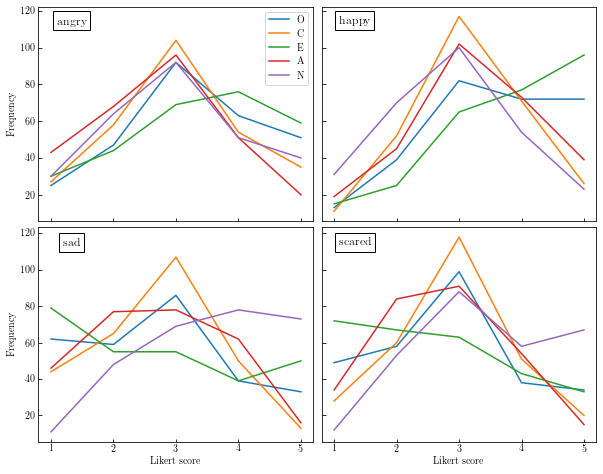

In [50]:
distr_plot_all()
plt.savefig('score_distr.png')

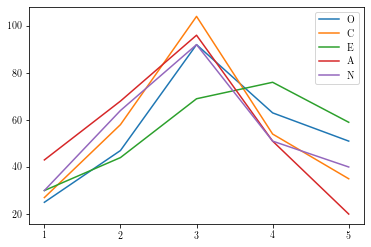

In [51]:
y_an = np.array(distr_df.iloc[:5, :5])
distr_plot(y_an)

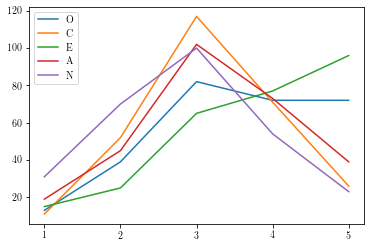

In [52]:
y_ha = np.array(distr_df.iloc[5:10, :5])
distr_plot(y_ha)

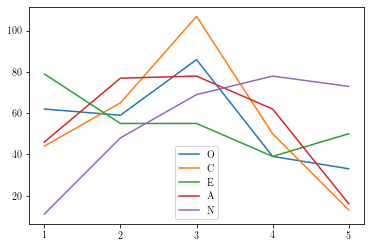

In [53]:
y_sa = np.array(distr_df.iloc[10:15, :5])
distr_plot(y_sa)

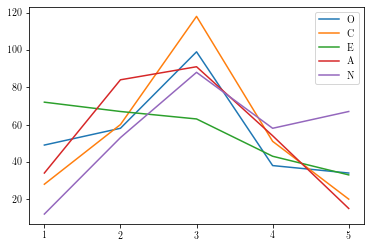

In [54]:
y_sc = np.array(distr_df.iloc[15:20, :5])
distr_plot(y_sc)

##  Individual Images

In [69]:
per_img_mean_df[per_img_mean_df['emotion'] == 'happy']
#ha02 vs ha08 for extraversion

,img,extraversion,agreeableness,conscientiousness,neuroticism,openness,emotion
10,ha01,4.085714,2.971429,2.823529,2.971429,3.542857,happy
11,ha02,4.285714,3.571429,3.571429,2.457143,4.142857,happy
12,ha03,3.529412,2.911765,2.882353,3.088235,3.382353,happy
13,ha04,3.771429,3.514286,3.171429,2.800000,3.485714,happy
14,ha05,4.028571,3.485714,3.200000,2.828571,3.514286,happy
15,ha06,4.117647,3.294118,2.970588,2.764706,3.882353,happy
16,ha07,4.114286,2.714286,2.742857,3.285714,3.400000,happy
17,ha08,2.771429,2.914286,3.085714,3.400000,2.714286,happy
18,ha09,3.457143,3.000000,3.085714,2.885714,3.342857,happy
19,ha10,4.235294,3.205882,2.882353,2.970588,3.941176,happy


In [70]:
per_img_mean_df[per_img_mean_df['emotion'] == 'sad']
#sa03 vs sa05 for neuroticism

,img,extraversion,agreeableness,conscientiousness,neuroticism,openness,emotion
20,sa01,2.029412,3.000000,2.857143,3.628571,2.342857,sad
21,sa02,1.257143,2.142857,2.228571,4.457143,1.685714,sad
22,sa03,1.542857,2.571429,2.485714,4.200000,1.971429,sad
23,sa04,2.485714,2.314286,2.428571,3.571429,2.400000,sad
24,sa05,3.285714,2.857143,3.200000,2.657143,3.114286,sad
25,sa06,2.294118,3.088235,3.323529,3.088235,2.823529,sad
26,sa07,1.885714,2.971429,3.114286,3.828571,2.400000,sad
27,sa08,2.285714,2.485714,2.857143,3.371429,2.600000,sad
28,sa09,1.705882,2.647059,2.823529,3.676471,2.382353,sad
29,sa10,2.171429,2.657143,2.885714,4.171429,2.342857,sad


In [71]:
per_img_mean_df[per_img_mean_df['emotion'] == 'scared']
#sc05 vs sc08 for openness

,img,extraversion,agreeableness,conscientiousness,neuroticism,openness,emotion
30,sc01,3.514286,2.885714,2.617647,3.285714,3.428571,scared
31,sc02,3.885714,2.457143,2.457143,3.228571,3.457143,scared
32,sc03,3.428571,2.771429,2.542857,3.228571,3.171429,scared
33,sc04,3.514286,2.428571,3.200000,2.771429,3.000000,scared
34,sc05,1.714286,2.800000,2.857143,3.771429,2.457143,scared
35,sc06,2.142857,2.742857,2.428571,3.885714,2.228571,scared
36,sc07,3.342857,2.971429,3.257143,2.800000,3.314286,scared
37,sc08,3.971429,3.371429,3.028571,3.285714,3.857143,scared
38,sc09,3.617647,2.882353,2.794118,2.588235,3.382353,scared
39,sc10,2.571429,2.514286,2.800000,3.600000,2.571429,scared


In [72]:
per_img_mean_df[per_img_mean_df['extraversion'] >= 4.0]

,img,extraversion,agreeableness,conscientiousness,neuroticism,openness,emotion
0,an01,4.057143,3.085714,2.857143,2.714286,3.971429,angry
3,an04,4.057143,3.200000,3.142857,2.542857,4.028571,angry
10,ha01,4.085714,2.971429,2.823529,2.971429,3.542857,happy
11,ha02,4.285714,3.571429,3.571429,2.457143,4.142857,happy
14,ha05,4.028571,3.485714,3.200000,2.828571,3.514286,happy
15,ha06,4.117647,3.294118,2.970588,2.764706,3.882353,happy
16,ha07,4.114286,2.714286,2.742857,3.285714,3.400000,happy
19,ha10,4.235294,3.205882,2.882353,2.970588,3.941176,happy


In [73]:
per_img_mean_df[per_img_mean_df['agreeableness'] > 3.3]

,img,extraversion,agreeableness,conscientiousness,neuroticism,openness,emotion
9,an10,3.628571,3.400000,3.400000,2.942857,3.600000,angry
11,ha02,4.285714,3.571429,3.571429,2.457143,4.142857,happy
13,ha04,3.771429,3.514286,3.171429,2.800000,3.485714,happy
14,ha05,4.028571,3.485714,3.200000,2.828571,3.514286,happy
37,sc08,3.971429,3.371429,3.028571,3.285714,3.857143,scared


In [74]:
per_img_mean_df[per_img_mean_df['conscientiousness'] > 3.3]

,img,extraversion,agreeableness,conscientiousness,neuroticism,openness,emotion
2,an03,2.685714,3.142857,3.485714,2.828571,3.171429,angry
8,an09,2.714286,2.800000,3.371429,3.228571,2.800000,angry
9,an10,3.628571,3.400000,3.400000,2.942857,3.600000,angry
11,ha02,4.285714,3.571429,3.571429,2.457143,4.142857,happy
25,sa06,2.294118,3.088235,3.323529,3.088235,2.823529,sad


In [75]:
per_img_mean_df[per_img_mean_df['neuroticism'] > 3.6]

,img,extraversion,agreeableness,conscientiousness,neuroticism,openness,emotion
20,sa01,2.029412,3.000000,2.857143,3.628571,2.342857,sad
21,sa02,1.257143,2.142857,2.228571,4.457143,1.685714,sad
22,sa03,1.542857,2.571429,2.485714,4.200000,1.971429,sad
26,sa07,1.885714,2.971429,3.114286,3.828571,2.400000,sad
28,sa09,1.705882,2.647059,2.823529,3.676471,2.382353,sad
29,sa10,2.171429,2.657143,2.885714,4.171429,2.342857,sad
34,sc05,1.714286,2.800000,2.857143,3.771429,2.457143,scared
35,sc06,2.142857,2.742857,2.428571,3.885714,2.228571,scared


In [76]:
per_img_mean_df[per_img_mean_df['openness'] > 3.8]

,img,extraversion,agreeableness,conscientiousness,neuroticism,openness,emotion
0,an01,4.057143,3.085714,2.857143,2.714286,3.971429,angry
3,an04,4.057143,3.200000,3.142857,2.542857,4.028571,angry
11,ha02,4.285714,3.571429,3.571429,2.457143,4.142857,happy
15,ha06,4.117647,3.294118,2.970588,2.764706,3.882353,happy
19,ha10,4.235294,3.205882,2.882353,2.970588,3.941176,happy
37,sc08,3.971429,3.371429,3.028571,3.285714,3.857143,scared


In [77]:
def get_scores(img_name):
    scores = list(per_img_mean_df[per_img_mean_df['img'] == img_name].iloc[0, 1:6])
    order = [4, 2, 0, 1, 3]
    scores = [scores[i] for i in order]
    return scores

In [78]:
def plot_radar(scores1, scores2):
    # categories
    categories = ['O', 'C', 'E', 'A', 'N']
    N = len(categories) # get number of categories
    
    # values
    values= scores1
    values += values[:1] # repeat first value to close poly
    values2 = scores2
    values2 += values2[:1]
    # calculate angle for each category
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1] # repeat first angle to close poly
    # plot
    plt.polar(angles, values, marker='.') # lines
    plt.fill(angles, values, alpha=0.3) # area
    plt.polar(angles, values2 , marker='.')
    plt.fill(angles, values2, alpha=0.3) # area
    
    # xticks
    plt.xticks(angles[:-1], categories)
    # yticks
#     ax.set_rlabel_position(0) # yticks position
    plt.yticks([1, 2, 3, 4, 5], color="grey", size=10)
    plt.ylim(0,5)

In [79]:
def plot_img(name):
    img = io.imread('imgs/' + name + '.jpg')
    plt.imshow(img)
    ax.axis('off')

In [80]:
def plot_vs(name1, name2, save=False):
    fig = plt.figure(figsize=(15, 5))
    ax = plt.subplot(131)
    plot_img(name1)
    ax = plt.subplot(132, polar='True')
    plot_radar(get_scores(name1), get_scores(name2))
    ax.legend(['left', 'right'])
    ax = plt.subplot(133)
    plot_img(name2)
    if save:
        plt.savefig('{}_{}.png'.format(name1, name2))

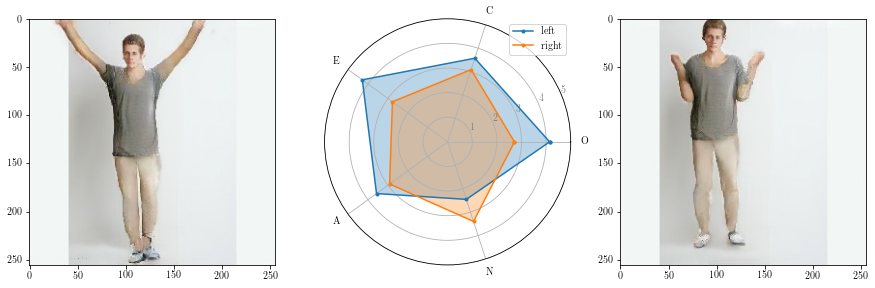

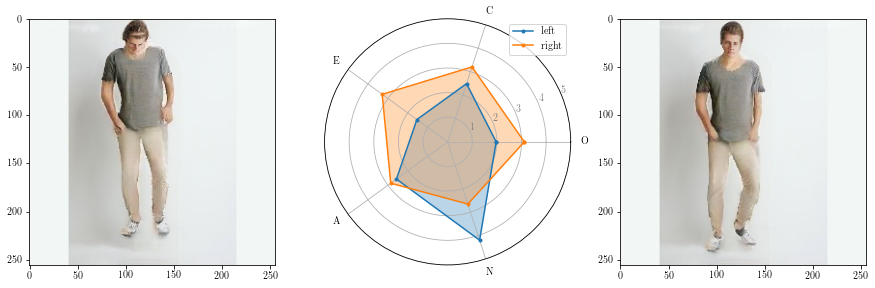

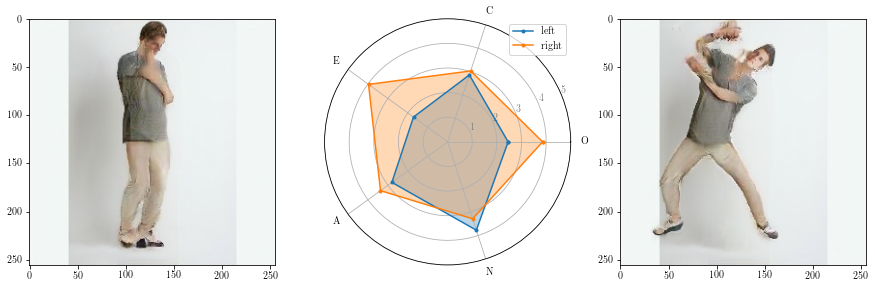

In [81]:
plot_vs('ha02','ha08') # extraversion
plot_vs('sa03','sa05') # neuroticism
plot_vs('sc05','sc08') # openness

# ANOVA and Post-hoc

### Extraversion

/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

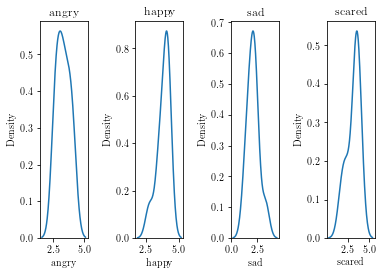

In [82]:
# check density distribution
fig, ax = plt.subplots(1, 4)
plt.subplots_adjust(wspace=1.0, hspace=0.5)
emotions = ['angry', 'happy', 'sad', 'scared']
for i in range(4):
    sns.distplot(E.iloc[:, i], hist=False, kde=True, ax=ax[i])
    ax[i].set_title(emotions[i])
    

In [83]:
model = ols('extraversion ~ C(emotion)', per_img_mean_df, eval_env=2).fit()
# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .6f}, p = {model.f_pvalue: .6f}")

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

# p < 0.05, so the differences between 
#the means of the groups are statistically significant

Overall model F( 3, 36) =  15.061641, p =  0.000002


,sum_sq,df,F,PR(>F)
C(emotion),16.004364,3.0,15.061641,0.000002
Residual,12.751092,36.0,NaN,NaN


0.9707826375961304 0.380920946598053


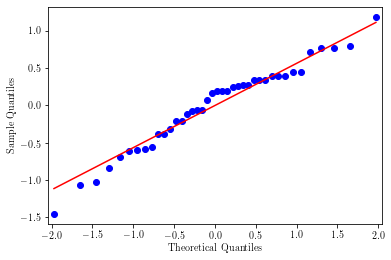

In [84]:
# normality assumption check
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

res = model.resid
fig = sm.qqplot(res, line='s')
plt.show()

# normality holds

In [85]:
stats.levene(E.angry, E.happy, E.sad, E.scared)

# pvalue >= 0.05, so homogeneity of variance holds

LeveneResult(statistic=0.3748734083129304, pvalue=0.7716268469354203)

In [86]:
m_comp = pairwise_tukeyhsd(endog=per_img_mean_df['extraversion'], groups=per_img_mean_df['emotion'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 angry  happy   0.5471 0.1873 -0.1698  1.2639  False
 angry    sad  -1.1982  0.001 -1.9151 -0.4814   True
 angry scared  -0.1223    0.9 -0.8391  0.5946  False
 happy    sad  -1.7453  0.001 -2.4621 -1.0285   True
 happy scared  -0.6693 0.0746 -1.3862  0.0475  False
   sad scared    1.076 0.0015  0.3591  1.7928   True
----------------------------------------------------


### Agreeableness

/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

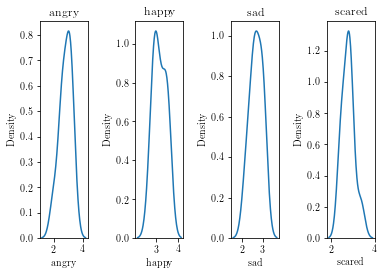

In [87]:
# check density distribution
fig, ax = plt.subplots(1, 4)
plt.subplots_adjust(wspace=1.0, hspace=0.5)
emotions = ['angry', 'happy', 'sad', 'scared']

for i in range(4):
    sns.distplot(A.iloc[:, i], hist=False, kde=True, ax=ax[i])
    ax[i].set_title(emotions[i])

In [88]:
model = ols('agreeableness ~ C(emotion)', per_img_mean_df, eval_env=2).fit()
# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .6f}, p = {model.f_pvalue: .6f}")

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

# p < 0.05, so the differences between 
#the means of the groups are statistically significant

Overall model F( 3, 36) =  3.935670, p =  0.015825


,sum_sq,df,F,PR(>F)
C(emotion),1.303196,3.0,3.93567,0.015825
Residual,3.973492,36.0,NaN,NaN


0.980742335319519 0.7170772552490234


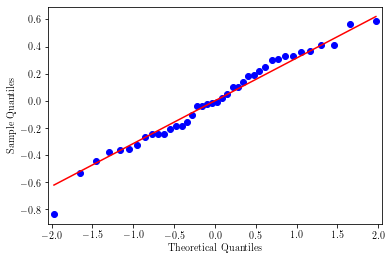

In [89]:
# normality assumption check
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

res = model.resid
fig = sm.qqplot(res, line='s')
plt.show()

# normality holds

In [90]:
stats.levene(A.angry, A.happy, A.sad, A.scared)

# pvalue >= 0.05, so homogeneity of variance holds

LeveneResult(statistic=0.9821603441292438, pvalue=0.4119885491339973)

In [91]:
m_comp = pairwise_tukeyhsd(endog=per_img_mean_df['agreeableness'], groups=per_img_mean_df['emotion'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 angry  happy   0.3224 0.1513 -0.0778  0.7225  False
 angry    sad  -0.1624 0.6762 -0.5626  0.2377  False
 angry scared  -0.0534    0.9 -0.4536  0.3467  False
 happy    sad  -0.4848 0.0124 -0.8849 -0.0846   True
 happy scared  -0.3758 0.0723  -0.776  0.0244  False
   sad scared    0.109 0.8748 -0.2912  0.5091  False
----------------------------------------------------


### Conscientiousness

/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

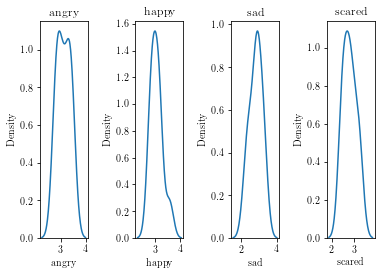

In [92]:
# check density distribution
fig, ax = plt.subplots(1, 4)
plt.subplots_adjust(wspace=1.0, hspace=0.5)
emotions = ['angry', 'happy', 'sad', 'scared']

for i in range(4):
    sns.distplot(C.iloc[:, i], hist=False, kde=True, ax=ax[i])
    ax[i].set_title(emotions[i])

In [93]:
model = ols('conscientiousness ~ C(emotion)', per_img_mean_df, eval_env=2).fit()
# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .6f}, p = {model.f_pvalue: .6f}")

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

# p < 0.05, so the differences between 
#the means of the groups are statistically significant

Overall model F( 3, 36) =  2.934547, p =  0.046388


,sum_sq,df,F,PR(>F)
C(emotion),0.743883,3.0,2.934547,0.046388
Residual,3.041901,36.0,NaN,NaN


0.9752293229103088 0.5177009105682373


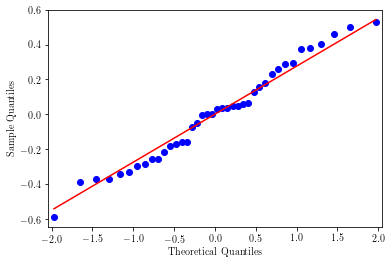

In [94]:
# normality assumption check
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

res = model.resid
fig = sm.qqplot(res, line='s')
plt.show()

# normality holds

In [95]:
stats.levene(C.angry, C.happy, C.sad, C.scared)

# pvalue >= 0.05, so homogeneity of variance holds

LeveneResult(statistic=0.33393360577693754, pvalue=0.8008524714333496)

In [96]:
m_comp = pairwise_tukeyhsd(endog=per_img_mean_df['conscientiousness'], groups=per_img_mean_df['emotion'], alpha=0.10)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.10 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 angry  happy  -0.0708    0.9 -0.3798  0.2381  False
 angry    sad   -0.292 0.1301  -0.601  0.0169  False
 angry scared  -0.3141  0.092 -0.6231 -0.0052   True
 happy    sad  -0.2212 0.3381 -0.5301  0.0878  False
 happy scared  -0.2433 0.2582 -0.5522  0.0657  False
   sad scared  -0.0221    0.9  -0.331  0.2868  False
----------------------------------------------------


### Neuroticism

/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

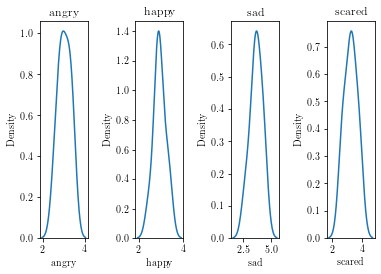

In [97]:
# check density distribution
fig, ax = plt.subplots(1, 4)
plt.subplots_adjust(wspace=1.0, hspace=0.5)
emotions = ['angry', 'happy', 'sad', 'scared']

for i in range(4):
    sns.distplot(N.iloc[:, i], hist=False, kde=True, ax=ax[i])
    ax[i].set_title(emotions[i])

In [98]:
model = ols('neuroticism ~ C(emotion)', per_img_mean_df, eval_env=2).fit()
# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .6f}, p = {model.f_pvalue: .6f}")

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

# p < 0.05, so the differences between 
#the means of the groups are statistically significant

Overall model F( 3, 36) =  6.353196, p =  0.001436


,sum_sq,df,F,PR(>F)
C(emotion),3.067047,3.0,6.353196,0.001436
Residual,5.793080,36.0,NaN,NaN


0.9845696091651917 0.8509364724159241


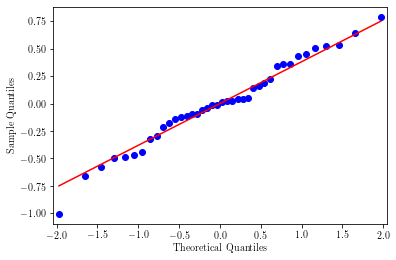

In [99]:
# normality assumption check
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

res = model.resid
fig = sm.qqplot(res, line='s')
plt.show()

# normality holds

In [100]:
stats.levene(N.angry, N.happy, N.sad, N.scared)

# pvalue >= 0.05, so homogeneity of variance holds

LeveneResult(statistic=1.3134375953911899, pvalue=0.2850384257418519)

In [101]:
m_comp = pairwise_tukeyhsd(endog=per_img_mean_df['neuroticism'], groups=per_img_mean_df['emotion'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 angry  happy  -0.0943    0.9 -0.5775 0.3889  False
 angry    sad   0.6255 0.0068  0.1424 1.1087   True
 angry scared    0.205 0.6488 -0.2781 0.6882  False
 happy    sad   0.7198 0.0016  0.2367  1.203   True
 happy scared   0.2993 0.3553 -0.1838 0.7825  False
   sad scared  -0.4205  0.107 -0.9037 0.0627  False
---------------------------------------------------


In [102]:
per_img_mean_df.head()

,img,extraversion,agreeableness,conscientiousness,neuroticism,openness,emotion
0,an01,4.057143,3.085714,2.857143,2.714286,3.971429,angry
1,an02,3.235294,2.000000,3.294118,3.088235,2.970588,angry
2,an03,2.685714,3.142857,3.485714,2.828571,3.171429,angry
3,an04,4.057143,3.200000,3.142857,2.542857,4.028571,angry
4,an05,3.085714,2.457143,2.942857,3.400000,2.971429,angry


### Openness

/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

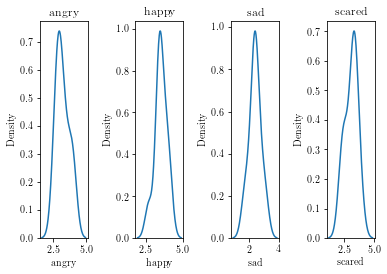

In [103]:
# check density distribution
fig, ax = plt.subplots(1, 4)
plt.subplots_adjust(wspace=1.0, hspace=0.5)
emotions = ['angry', 'happy', 'sad', 'scared']

for i in range(4):
    sns.distplot(O.iloc[:, i], hist=False, kde=True, ax=ax[i])
    ax[i].set_title(emotions[i])

In [104]:
model = ols('openness ~ C(emotion)', per_img_mean_df, eval_env=2).fit()
# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .6f}, p = {model.f_pvalue: .6f}")

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

# p < 0.05, so the differences between 
#the means of the groups are statistically significant

Overall model F( 3, 36) =  11.060954, p =  0.000027


,sum_sq,df,F,PR(>F)
C(emotion),6.836541,3.0,11.060954,0.000027
Residual,7.416946,36.0,NaN,NaN


0.9738382697105408 0.4718610942363739


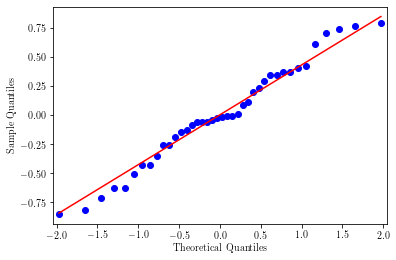

In [105]:
# normality assumption check
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

res = model.resid
fig = sm.qqplot(res, line='s')
plt.show()

# normality holds

In [106]:
stats.levene(O.angry, O.happy, O.sad, O.scared)

# pvalue >= 0.05, so homogeneity of variance holds

LeveneResult(statistic=0.5946469605712307, pvalue=0.6225901192740866)

In [107]:
m_comp = pairwise_tukeyhsd(endog=per_img_mean_df['openness'], groups=per_img_mean_df['emotion'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 angry  happy    0.301 0.4593 -0.2457  0.8477  False
 angry    sad  -0.8276 0.0013 -1.3743 -0.2809   True
 angry scared  -0.1471 0.8798 -0.6938  0.3996  False
 happy    sad  -1.1286  0.001 -1.6753 -0.5819   True
 happy scared  -0.4481 0.1405 -0.9948  0.0986  False
   sad scared   0.6805 0.0098  0.1338  1.2272   True
----------------------------------------------------


# Suggestion 2

In [108]:
evals.head()

,an01_01,an01_02,an01_03,an01_04,an01_05,an02_01,an02_02,an02_03,an02_04,an02_05,...,sc09_01,sc09_02,sc09_03,sc09_04,sc09_05,sc10_01,sc10_02,sc10_03,sc10_04,sc10_05
0,3.0,3.0,3.0,3.0,3.0,4.0,2.0,4.0,2.0,3.0,...,3.0,2.0,2.0,4.0,3.0,2.0,3.0,2.0,4.0,3.0
1,4.0,1.0,3.0,2.0,4.0,2.0,1.0,3.0,2.0,3.0,...,4.0,2.0,2.0,1.0,3.0,4.0,2.0,3.0,2.0,4.0
2,3.0,3.0,4.0,2.0,4.0,4.0,1.0,4.0,3.0,4.0,...,4.0,4.0,5.0,1.0,5.0,3.0,3.0,3.0,3.0,3.0
3,4.0,2.0,2.0,3.0,4.0,4.0,2.0,1.0,4.0,4.0,...,4.0,2.0,3.0,4.0,1.0,4.0,2.0,2.0,2.0,1.0
4,5.0,1.0,1.0,5.0,5.0,2.0,2.0,5.0,3.0,2.0,...,4.0,2.0,2.0,3.0,2.0,4.0,4.0,2.0,4.0,2.0


In [109]:
rows = []

for i in range(len(evals.columns)//5):
    for j in range(len(evals)):
        cols = evals.columns[i*5:(i+1)*5]
        row = list(evals.loc[j, cols])
        row.append(cols[0][:2])
        rows.append(row)

In [110]:
evals_new = pd.DataFrame(rows, columns=['E', 'A', 'C', 'N', 'O', 'emotion'])

In [111]:
evals_new.head()

,E,A,C,N,O,emotion
0,3.0,3.0,3.0,3.0,3.0,an
1,4.0,1.0,3.0,2.0,4.0,an
2,3.0,3.0,4.0,2.0,4.0,an
3,4.0,2.0,2.0,3.0,4.0,an
4,5.0,1.0,1.0,5.0,5.0,an


In [112]:
evals_new.describe()

,E,A,C,N,O
count,1391.000000,1392.000000,1390.000000,1391.000000,1392.000000
mean,3.099209,2.862787,2.943165,3.224299,3.064655
std,1.387589,1.122540,1.068062,1.196523,1.263370
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000
75%,4.000000,4.000000,4.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000


In [113]:
evals_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   E        1391 non-null   float64
 1   A        1392 non-null   float64
 2   C        1390 non-null   float64
 3   N        1391 non-null   float64
 4   O        1392 non-null   float64
 5   emotion  1400 non-null   object 
dtypes: float64(5), object(1)
memory usage: 65.8+ KB


In [114]:
evals_new.dropna(inplace=True)
evals_new.reset_index(drop=True, inplace=True)
evals_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1388 entries, 0 to 1387
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   E        1388 non-null   float64
 1   A        1388 non-null   float64
 2   C        1388 non-null   float64
 3   N        1388 non-null   float64
 4   O        1388 non-null   float64
 5   emotion  1388 non-null   object 
dtypes: float64(5), object(1)
memory usage: 65.2+ KB


In [115]:
def welch_anova_np(*args, var_equal=False):
    # https://svn.r-project.org/R/trunk/src/library/stats/R/oneway.test.R
    # translated from R Welch ANOVA (not assuming equal variance)

    F_onewayResult = namedtuple('F_onewayResult', ('statistic', 'pvalue'))

    args = [np.asarray(arg, dtype=float) for arg in args]
    k = len(args)
    ni =np.array([len(arg) for arg in args])
    mi =np.array([np.mean(arg) for arg in args])
    vi =np.array([np.var(arg,ddof=1) for arg in args])
    wi = ni/vi

    tmp =sum((1-wi/sum(wi))**2 / (ni-1))
    tmp /= (k**2 -1)

    dfbn = k - 1
    dfwn = 1 / (3 * tmp)

    m = sum(mi*wi) / sum(wi)
    f = sum(wi * (mi - m)**2) /((dfbn) * (1 + 2 * (dfbn - 1) * tmp))
    prob = stats.f.sf(dfbn, dfwn, f)   # equivalent to stats.f.sf
    return F_onewayResult(f, prob)

### Extraversion

/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

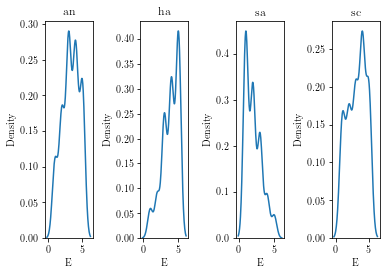

In [117]:
fig, ax = plt.subplots(1, 4)
plt.subplots_adjust(wspace=1.0, hspace=0.5)
emotions = ['an', 'ha', 'sa', 'sc']

for i, em in enumerate(emotions):
    data = evals_new['E'][evals_new['emotion'] == em]
    sns.distplot(data, hist=False, kde=True, ax=ax[i])
    ax[i].set_title(em)

In [118]:
model = ols('E ~ emotion', data=evals_new, eval_env=2).fit()
# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .6f}, p = {model.f_pvalue: .6f}")

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

# p < 0.05, so the differences between 
#the means of the groups are statistically significant

Overall model F( 3, 1384) =  120.710466, p =  0.000000


,sum_sq,df,F,PR(>F)
emotion,553.957121,3.0,120.710466,1.911064e-69
Residual,2117.122850,1384.0,NaN,NaN


0.9691706895828247 1.251668262393764e-16


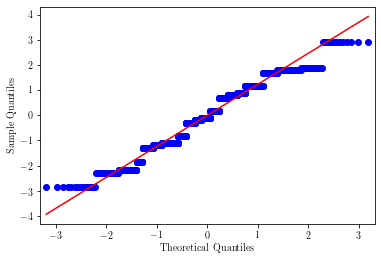

In [119]:
# normality assumption check
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

res = model.resid
fig = sm.qqplot(res, line='s')
plt.show()

# normality does NOT hold

In [120]:
stats.levene(evals_new['E'][evals_new['emotion'] == 'an'],
              evals_new['E'][evals_new['emotion'] == 'ha'],
              evals_new['E'][evals_new['emotion'] == 'sa'],
              evals_new['E'][evals_new['emotion'] == 'sc']
            )

# pvalue <= 0.05, so homogeneity of variance does not hold

LeveneResult(statistic=11.962868769801103, pvalue=9.815829303824849e-08)

In [121]:
# Applying Kruskal test instead of ANOVA
stats.kruskal(evals_new['E'][evals_new['emotion'] == 'an'],
              evals_new['E'][evals_new['emotion'] == 'ha'],
              evals_new['E'][evals_new['emotion'] == 'sa'],
              evals_new['E'][evals_new['emotion'] == 'sc']
             )

KruskalResult(statistic=285.1768556725031, pvalue=1.605627404263545e-61)

In [122]:
# Welch ANOVA
welch_anova_np(evals_new['E'][evals_new['emotion'] == 'an'],
              evals_new['E'][evals_new['emotion'] == 'ha'],
              evals_new['E'][evals_new['emotion'] == 'sa'],
              evals_new['E'][evals_new['emotion'] == 'sc']
              )

F_onewayResult(statistic=139.52090529531327, pvalue=7.326247487972963e-14)

In [123]:
m_comp = pairwise_tukeyhsd(endog=evals_new['E'], groups=evals_new['emotion'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    an     ha   0.5442  0.001  0.3025  0.7859   True
    an     sa  -1.1988  0.001 -1.4404 -0.9573   True
    an     sc  -0.1187 0.5755   -0.36  0.1227  False
    ha     sa   -1.743  0.001 -1.9847 -1.5014   True
    ha     sc  -0.6629  0.001 -0.9044 -0.4213   True
    sa     sc   1.0802  0.001  0.8388  1.3215   True
----------------------------------------------------


In [124]:
sp.posthoc_dunn([evals_new['E'][evals_new['emotion'] == 'an'],
              evals_new['E'][evals_new['emotion'] == 'ha'],
              evals_new['E'][evals_new['emotion'] == 'sa'],
              evals_new['E'][evals_new['emotion'] == 'sc']])

,1,2,3,4
1,1.000000e+00,1.358360e-07,3.042608e-29,3.060742e-01
2,1.358360e-07,1.000000e+00,4.431455e-61,3.028121e-10
3,3.042608e-29,4.431455e-61,1.000000e+00,1.779777e-24
4,3.060742e-01,3.028121e-10,1.779777e-24,1.000000e+00


### Agreeableness

/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

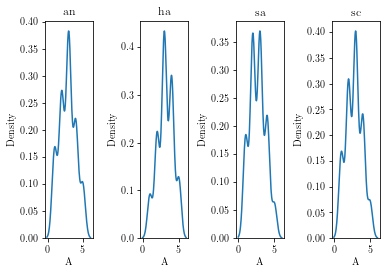

In [126]:
fig, ax = plt.subplots(1, 4)
plt.subplots_adjust(wspace=1.0, hspace=0.5)
emotions = ['an', 'ha', 'sa', 'sc']

for i, em in enumerate(emotions):
    data = evals_new['A'][evals_new['emotion'] == em]
    sns.distplot(data, hist=False, kde=True, ax=ax[i])
    ax[i].set_title(em)

In [127]:
model = ols('A ~ emotion', data=evals_new, eval_env=2).fit()
# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .6f}, p = {model.f_pvalue: .6f}")

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

Overall model F( 3, 1384) =  12.053730, p =  0.000000


,sum_sq,df,F,PR(>F)
emotion,44.578040,3.0,12.05373,8.624921e-08
Residual,1706.138818,1384.0,NaN,NaN


0.968906044960022 1.0470487927898687e-16


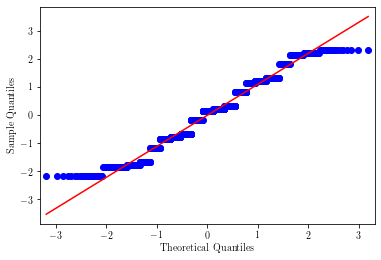

In [128]:
# normality assumption check
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

res = model.resid
fig = sm.qqplot(res, line='s')
plt.show()

# normality does NOT hold

In [129]:
stats.levene(evals_new['A'][evals_new['emotion'] == 'an'],
              evals_new['A'][evals_new['emotion'] == 'ha'],
              evals_new['A'][evals_new['emotion'] == 'sa'],
              evals_new['A'][evals_new['emotion'] == 'sc']
            )

# pvalue >= 0.05, so homogeneity of variance holds

LeveneResult(statistic=0.8849286081927359, pvalue=0.4482390324892095)

In [130]:
# Applying Kruskal test instead of ANOVA
stats.kruskal(evals_new['A'][evals_new['emotion'] == 'an'],
              evals_new['A'][evals_new['emotion'] == 'ha'],
              evals_new['A'][evals_new['emotion'] == 'sa'],
              evals_new['A'][evals_new['emotion'] == 'sc']
             )

KruskalResult(statistic=36.48335343954831, pvalue=5.9180277383777476e-08)

In [131]:
m_comp = pairwise_tukeyhsd(endog=evals_new['A'], groups=evals_new['emotion'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    an     ha   0.3175  0.001  0.1005  0.5344   True
    an     sa  -0.1643 0.2084 -0.3811  0.0525  False
    an     sc   -0.057    0.9 -0.2737  0.1597  False
    ha     sa  -0.4817  0.001 -0.6987 -0.2647   True
    ha     sc  -0.3745  0.001 -0.5913 -0.1576   True
    sa     sc   0.1073 0.5706 -0.1094  0.3239  False
----------------------------------------------------


### Conscientiousness

/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

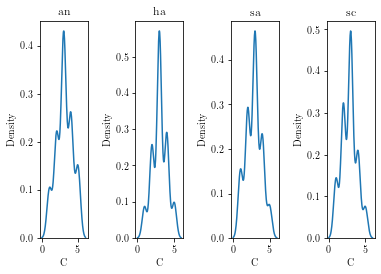

In [132]:
fig, ax = plt.subplots(1, 4)
plt.subplots_adjust(wspace=1.0, hspace=0.5)
emotions = ['an', 'ha', 'sa', 'sc']

for i, em in enumerate(emotions):
    data = evals_new['C'][evals_new['emotion'] == em]
    sns.distplot(data, hist=False, kde=True, ax=ax[i])
    ax[i].set_title(em)

In [133]:
model = ols('C ~ emotion', data=evals_new, eval_env=2).fit()
# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .6f}, p = {model.f_pvalue: .6f}")

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

Overall model F( 3, 1384) =  7.820066, p =  0.000035


,sum_sq,df,F,PR(>F)
emotion,26.396455,3.0,7.820066,0.000035
Residual,1557.220260,1384.0,NaN,NaN


0.9622931480407715 1.6540214606694492e-18


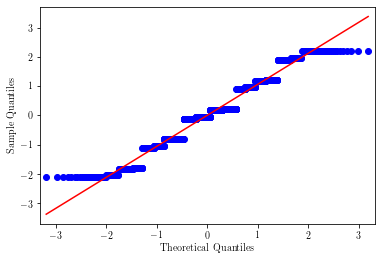

In [134]:
# normality assumption check
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

res = model.resid
fig = sm.qqplot(res, line='s')
plt.show()

# normality does NOT hold

In [135]:
stats.levene(evals_new['C'][evals_new['emotion'] == 'an'],
              evals_new['C'][evals_new['emotion'] == 'ha'],
              evals_new['C'][evals_new['emotion'] == 'sa'],
              evals_new['C'][evals_new['emotion'] == 'sc']
            )

# pvalue >= 0.05, so homogeneity of variance holds

LeveneResult(statistic=2.422403283985814, pvalue=0.06431893978294526)

In [136]:
# Applying Kruskal test instead of ANOVA
stats.kruskal(evals_new['C'][evals_new['emotion'] == 'an'],
              evals_new['C'][evals_new['emotion'] == 'ha'],
              evals_new['C'][evals_new['emotion'] == 'sa'],
              evals_new['C'][evals_new['emotion'] == 'sc']
             )

KruskalResult(statistic=22.57612788226291, pvalue=4.948997121009036e-05)

In [137]:
m_comp = pairwise_tukeyhsd(endog=evals_new['C'], groups=evals_new['emotion'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    an     ha  -0.0719 0.7843 -0.2792  0.1354  False
    an     sa  -0.2968 0.0014  -0.504 -0.0897   True
    an     sc  -0.3164  0.001 -0.5234 -0.1094   True
    ha     sa  -0.2249 0.0273 -0.4322 -0.0176   True
    ha     sc  -0.2445  0.013 -0.4516 -0.0374   True
    sa     sc  -0.0196    0.9 -0.2266  0.1874  False
----------------------------------------------------


In [140]:
res = sp.posthoc_dunn([evals_new['C'][evals_new['emotion'] == 'an'],
              evals_new['C'][evals_new['emotion'] == 'ha'],
              evals_new['C'][evals_new['emotion'] == 'sa'],
              evals_new['C'][evals_new['emotion'] == 'sc']])

In [141]:
res.rename({1:'an', 2:'ha', 3:'sa', 4:'sc'}, axis=0, inplace=True)

In [142]:
res

,1,2,3,4
an,1.000000,0.448045,0.000456,0.000109
ha,0.448045,1.000000,0.006066,0.001892
sa,0.000456,0.006066,1.000000,0.718246
sc,0.000109,0.001892,0.718246,1.000000


### Neuroticism

/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

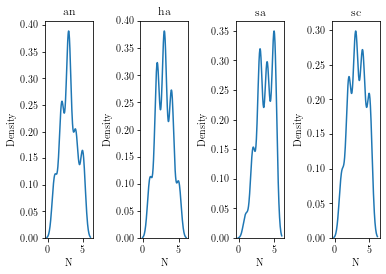

In [143]:
fig, ax = plt.subplots(1, 4)
plt.subplots_adjust(wspace=1.0, hspace=0.5)
emotions = ['an', 'ha', 'sa', 'sc']

for i, em in enumerate(emotions):
    data = evals_new['N'][evals_new['emotion'] == em]
    sns.distplot(data, hist=False, kde=True, ax=ax[i])
    ax[i].set_title(em)

In [144]:
model = ols('N ~ emotion', data=evals_new, eval_env=2).fit()
# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .6f}, p = {model.f_pvalue: .6f}")

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

Overall model F( 3, 1384) =  26.214335, p =  0.000000


,sum_sq,df,F,PR(>F)
emotion,106.793999,3.0,26.214335,1.713411e-16
Residual,1879.415656,1384.0,NaN,NaN


0.9715550541877747 6.575920698371855e-16


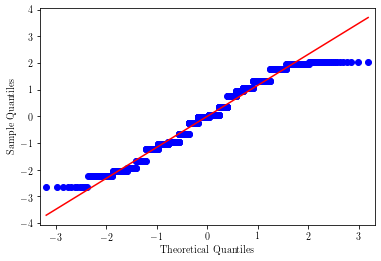

In [145]:
# normality assumption check
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

res = model.resid
fig = sm.qqplot(res, line='s')
plt.show()

# normality does NOT hold

In [146]:
stats.levene(evals_new['N'][evals_new['emotion'] == 'an'],
              evals_new['N'][evals_new['emotion'] == 'ha'],
              evals_new['N'][evals_new['emotion'] == 'sa'],
              evals_new['N'][evals_new['emotion'] == 'sc']
            )

# pvalue >= 0.05, so homogeneity of variance holds

LeveneResult(statistic=2.5648769351916254, pvalue=0.0532024587214943)

In [147]:
# Applying Kruskal test instead of ANOVA
stats.kruskal(evals_new['N'][evals_new['emotion'] == 'an'],
              evals_new['N'][evals_new['emotion'] == 'ha'],
              evals_new['N'][evals_new['emotion'] == 'sa'],
              evals_new['N'][evals_new['emotion'] == 'sc']
             )

KruskalResult(statistic=74.38883187131817, pvalue=4.898793030229312e-16)

In [148]:
m_comp = pairwise_tukeyhsd(endog=evals_new['N'], groups=evals_new['emotion'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    an     ha  -0.0924 0.6996 -0.3201  0.1353  False
    an     sa   0.6282  0.001  0.4007  0.8558   True
    an     sc   0.2039 0.0969 -0.0235  0.4313  False
    ha     sa   0.7206  0.001  0.4929  0.9483   True
    ha     sc   0.2963 0.0046  0.0687  0.5239   True
    sa     sc  -0.4243  0.001 -0.6517 -0.1969   True
----------------------------------------------------


### Openness

/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/khasmamad/miniconda3/envs/learn/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

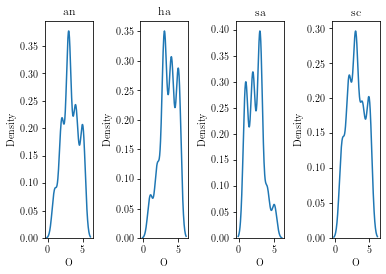

In [149]:
fig, ax = plt.subplots(1, 4)
plt.subplots_adjust(wspace=1.0, hspace=0.5)
emotions = ['an', 'ha', 'sa', 'sc']

for i, em in enumerate(emotions):
    data = evals_new['O'][evals_new['emotion'] == em]
    sns.distplot(data, hist=False, kde=True, ax=ax[i])
    ax[i].set_title(em)

In [150]:
model = ols('O ~ emotion', data=evals_new, eval_env=2).fit()
# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .6f}, p = {model.f_pvalue: .6f}")

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

Overall model F( 3, 1384) =  55.509412, p =  0.000000


,sum_sq,df,F,PR(>F)
emotion,237.438704,3.0,55.509412,6.999468e-34
Residual,1973.330028,1384.0,NaN,NaN


0.9735895395278931 2.928902076993205e-15


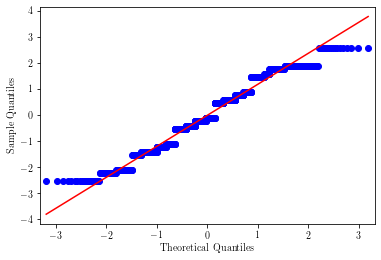

In [151]:
# normality assumption check
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

res = model.resid
fig = sm.qqplot(res, line='s')
plt.show()

# normality does NOT hold

In [152]:
stats.levene(evals_new['O'][evals_new['emotion'] == 'an'],
              evals_new['O'][evals_new['emotion'] == 'ha'],
              evals_new['O'][evals_new['emotion'] == 'sa'],
              evals_new['O'][evals_new['emotion'] == 'sc']
            )

# pvalue >= 0.05, so homogeneity of variance holds

LeveneResult(statistic=1.93379094137635, pvalue=0.12221536536461963)

In [153]:
# Applying Kruskal test instead of ANOVA
stats.kruskal(evals_new['O'][evals_new['emotion'] == 'an'],
              evals_new['O'][evals_new['emotion'] == 'ha'],
              evals_new['O'][evals_new['emotion'] == 'sa'],
              evals_new['O'][evals_new['emotion'] == 'sc']
             )

KruskalResult(statistic=150.67859368449922, pvalue=1.8809577919367487e-32)

In [154]:
m_comp = pairwise_tukeyhsd(endog=evals_new['O'], groups=evals_new['emotion'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    an     ha    0.307 0.0041  0.0737  0.5404   True
    an     sa  -0.8242  0.001 -1.0574  -0.591   True
    an     sc  -0.1472 0.3654 -0.3802  0.0858  False
    ha     sa  -1.1312  0.001 -1.3646 -0.8979   True
    ha     sc  -0.4543  0.001 -0.6874 -0.2211   True
    sa     sc    0.677  0.001   0.444    0.91   True
----------------------------------------------------
